In [2]:
import sys

In [3]:
from peewee import *
import base64

db = SqliteDatabase('2021-07-31-lichess-evaluations-37MM.db')

class Evaluations(Model):
  id = IntegerField()
  fen = TextField()
  binary = BlobField()
  eval = FloatField()

  class Meta:
    database = db

  def binary_base64(self):
    return base64.b64encode(self.binary)
db.connect()
LABEL_COUNT = 37164639
print(LABEL_COUNT)
eval = Evaluations.get(Evaluations.id == 1)
print(eval.binary_base64())

37164639
b'CAAAAAAAAAAQAAAAAAAAAIEAAAAAAAAAJAAAAAAAAABCAAAAAAAAAADvABAAAAAAAAAAAAAAAAgAAAAAAAAAEAAAAAAAAACBAAAAAAAAACQAAAAAAAAAQgAAAAAAAP8AAAABEz8='


In [4]:
count = Evaluations.select().count()
count

37164639

In [5]:
import pytorch_lightning as pl

In [6]:
import os
import torch
import numpy as np
from torch import nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, IterableDataset, random_split
import pytorch_lightning as pl
from random import randrange

class EvaluationDataset(IterableDataset):
  def __init__(self, count, subset_count=None):
    self.count = count
    self.subset_count = subset_count or count
  def __iter__(self):
    self.seen = 0
    return self
  def __next__(self):
    if self.seen >= self.subset_count:
        raise StopIteration
    idx = randrange(self.count)
    self.seen += 1
    return self[idx]
  def __len__(self):
    return self.subset_count
  def __getitem__(self, idx):
    eval = Evaluations.get(Evaluations.id == idx+1)
    bin = np.frombuffer(eval.binary, dtype=np.uint8)
    bin = np.unpackbits(bin, axis=0).astype(np.single)
    eval.eval = max(eval.eval, -15)
    eval.eval = min(eval.eval, 15)
    ev = np.array([eval.eval]).astype(np.single)
    return {'binary':bin, 'eval':ev}

dataset = EvaluationDataset(count=LABEL_COUNT)

In [10]:
import time
from collections import OrderedDict

class EvaluationModel(pl.LightningModule):
  def __init__(self,learning_rate=1e-3,batch_size=1024,layer_count=10, subset_count=LABEL_COUNT):
    super().__init__()
    self.batch_size = batch_size
    self.learning_rate = learning_rate
    self.subset_count = subset_count
    layers = []
    for i in range(layer_count-1):
      layers.append((f"linear-{i}", nn.Linear(808, 808)))
      layers.append((f"relu-{i}", nn.ReLU()))
    layers.append((f"linear-{layer_count-1}", nn.Linear(808, 1)))
    self.seq = nn.Sequential(OrderedDict(layers))

  def forward(self, x):
    return self.seq(x)

  def training_step(self, batch, batch_idx):
    x, y = batch['binary'], batch['eval']
    y_hat = self(x)
    loss = F.l1_loss(y_hat, y)
    self.log("train_loss", loss)
    return loss

  def configure_optimizers(self):
    optimizer = torch.optim.Adam(self.parameters(), lr=self.learning_rate, weight_decay=1e-4)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
        optimizer, 
        factor=0.5, 
        patience=2
    )
    return {"optimizer": optimizer, "lr_scheduler": scheduler, "monitor": "train_loss"}

  def train_dataloader(self):
    dataset = EvaluationDataset(count=LABEL_COUNT, subset_count=self.subset_count)
    return DataLoader(dataset, batch_size=self.batch_size, num_workers=0, pin_memory=True)
  
  def validation_step(self, batch, batch_idx):
    x, y = batch['binary'], batch['eval']
    pred = self(x)
    loss = F.l1_loss(pred, y)
    self.log("val_loss", loss, prog_bar=True)
    return loss

In [11]:
def train_with_config(config, learning_rate=1e-3, checkpoint="", checkpoint_folder=""):
    version_name = f'{int(time.time())}-batch_size-{config["batch_size"]}-layer_count-{config["layer_count"]}'
    logger = pl.loggers.TensorBoardLogger("lightning_logs", name="chessml", version=version_name)
    checkpoint_callback = pl.callbacks.ModelCheckpoint(dirpath=f"checkpoints\\{checkpoint_folder}",filename="model-{epoch:02d}-{train_loss:.4f}",save_top_k=3,monitor="train_loss",mode="min")
    trainer = pl.Trainer(precision=16, check_val_every_n_epoch=1, max_epochs=config["max_epochs"],logger=logger, callbacks=[checkpoint_callback])
    model = EvaluationModel(layer_count=config["layer_count"],batch_size=config["batch_size"],learning_rate=learning_rate,subset_count=config['subset_count'])
    # trainer.tune(model)
    # lr_finder = trainer.tuner.lr_find(model, min_lr=1e-6, max_lr=1e-3, num_training=25)
    # fig = lr_finder.plot(suggest=True)
    # fig.show()
    if checkpoint:
        trainer.fit(model, ckpt_path=checkpoint)
    else:
        trainer.fit(model)
    return model

In [13]:
train_with_config({"layer_count": 4, "batch_size": 256, "subset_count": 1000000, "max_epochs": 10},
                learning_rate=1e-4,
                checkpoint="checkpoints\\Model B\\model-epoch=06-train_loss=1.3086.ckpt",
                checkpoint_folder="Model B")

c:\Users\rober\AppData\Local\Programs\Python\Python311\Lib\site-packages\lightning_fabric\connector.py:571: `precision=16` is supported for historical reasons but its usage is discouraged. Please set your precision to 16-mixed instead!
c:\Users\rober\AppData\Local\Programs\Python\Python311\Lib\site-packages\pytorch_lightning\trainer\connectors\accelerator_connector.py:479: You passed `Trainer(accelerator='cpu', precision='16-mixed')` but AMP with fp16 is not supported on CPU. Using `precision='bf16-mixed'` instead.
Using bfloat16 Automatic Mixed Precision (AMP)
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
c:\Users\rober\AppData\Local\Programs\Python\Python311\Lib\site-packages\pytorch_lightning\trainer\configuration_validator.py:70: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.
c:\Users\rober\AppData\Local\Programs\Python\Python311\Lib\site-packages\pytorch_lightning\callbacks\model_checkpoint.py:751: Checkpoint directory

Epoch 8:   3%|▎         | 130/3907 [04:38<2:14:57,  0.47it/s, v_num=nt-4]   


Detected KeyboardInterrupt, attempting graceful shutdown ...


SystemExit: 1

C:\Users\rober\AppData\Roaming\Python\Python311\site-packages\IPython\core\interactiveshell.py:3707: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)


In [ ]:
train_with_config({"layer_count": 4, "batch_size": 256, "subset_count": 1000000, "max_epochs": 3}, checkpoint_folder="Model C")

c:\Users\rober\AppData\Local\Programs\Python\Python311\Lib\site-packages\lightning_fabric\connector.py:571: `precision=16` is supported for historical reasons but its usage is discouraged. Please set your precision to 16-mixed instead!
c:\Users\rober\AppData\Local\Programs\Python\Python311\Lib\site-packages\pytorch_lightning\trainer\connectors\accelerator_connector.py:479: You passed `Trainer(accelerator='cpu', precision='16-mixed')` but AMP with fp16 is not supported on CPU. Using `precision='bf16-mixed'` instead.
Using bfloat16 Automatic Mixed Precision (AMP)
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
c:\Users\rober\AppData\Local\Programs\Python\Python311\Lib\site-packages\pytorch_lightning\trainer\configuration_validator.py:70: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.
c:\Users\rober\AppData\Local\Programs\Python\Python311\Lib\site-packages\pytorch_lightning\utilities\model_summary\model_summary.py:231: Precision

Epoch 0:   1%|          | 19/1954 [01:43<2:55:02,  0.18it/s, v_num=nt-4]


Detected KeyboardInterrupt, attempting graceful shutdown ...


SystemExit: 1

C:\Users\rober\AppData\Roaming\Python\Python311\site-packages\IPython\core\interactiveshell.py:3707: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)


Idx 21573971 Eval 0.38 Prediction 5.57 Loss 5.19
FEN r4rk1/pp2ppbp/1n4p1/6B1/3QP2P/5P2/P3BP2/1R2K2R b K - 0 16


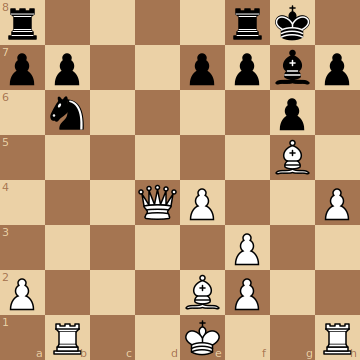

Idx 32905469 Eval 4.92 Prediction 1.36 Loss 3.56
FEN r1bqk2r/pppnn1b1/3ppp1p/6p1/3PP2P/2N2NB1/PPP2PP1/R2QKB1R w KQkq - 1 9


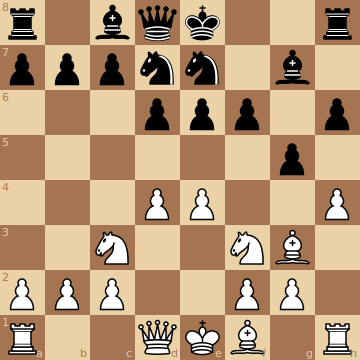

Idx 13303227 Eval 2.50 Prediction 1.78 Loss 0.72
FEN r3r1k1/pppq1ppp/2nb4/7b/3P4/2P2N1P/PP2BPP1/R1BQ1RK1 w - - 1 14


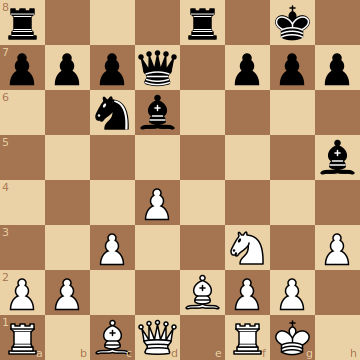

Idx 29969787 Eval -0.25 Prediction 0.16 Loss 0.41
FEN r1bqk2r/1pp1nppp/p1pb4/4p3/4P3/2NP1N2/PPP2PPP/R1BQK2R w KQkq - 3 7


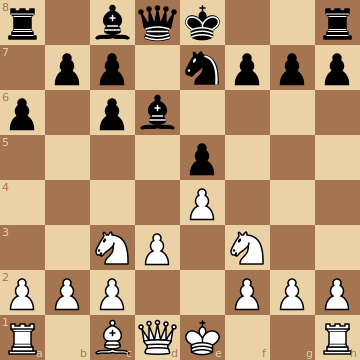

Idx 20710168 Eval 4.90 Prediction -0.58 Loss 5.48
FEN r1bq1b1r/pp4pp/2p1k1n1/3np3/2BP4/2N2Q2/PPP2PPP/R1B2RK1 w - - 1 11


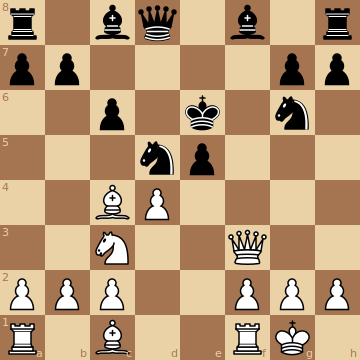

In [41]:
from IPython.display import display, SVG
from random import randrange

SVG_BASE_URL = "https://us-central1-spearsx.cloudfunctions.net/chesspic-fen-image/"

def svg_url(fen):
  fen_board = fen.split()[0]
  return SVG_BASE_URL + fen_board

def show_index(idx, model_idx=0):
  eval = Evaluations.select().where(Evaluations.id == idx+1).get()
  batch = dataset[idx]
  x, y = torch.tensor(batch['binary']), torch.tensor(batch['eval'])
  y_hat = models[model_idx](x)
  loss = F.l1_loss(y_hat, y)
  print(f'Idx {idx} Eval {y.data[0]:.2f} Prediction {y_hat.data[0]:.2f} Loss {loss:.2f}')
  print(f'FEN {eval.fen}')
  display(SVG(url=svg_url(eval.fen)))

for i in range(5):
  idx = randrange(LABEL_COUNT)
  show_index(idx, 2)

# need to do better on "tactics" like 700756

In [43]:
import chess

MATERIAL_LOOKUP = {chess.KING:0,chess.QUEEN:9,chess.ROOK:5,chess.BISHOP:3,chess.KNIGHT:3,chess.PAWN:1}

def avg(lst):
    return sum(lst) / len(lst)

def material_for_board(board):
  eval = 0.0
  for sq, piece in board.piece_map().items():
    mat = MATERIAL_LOOKUP[piece.piece_type]
    if piece.color == chess.BLACK:
      mat = mat * -1
    eval += mat
  return eval

def guess_zero_loss(idx):
  eval = Evaluations.select().where(Evaluations.id == idx+1).get()
  y = torch.tensor(eval.eval)
  y_hat = torch.zeros_like(y)
  loss = F.l1_loss(y_hat, y)
  return loss

def guess_material_loss(idx):
  eval = Evaluations.select().where(Evaluations.id == idx+1).get()
  board = chess.Board(eval.fen)
  y = torch.tensor(eval.eval)
  y_hat = torch.tensor(material_for_board(board))
  loss = F.l1_loss(y_hat, y)
  return loss

def guess_model_loss(idx, model_idx=0):
  eval = Evaluations.select().where(Evaluations.id == idx+1).get()
  batch = dataset[idx]
  x, y = torch.tensor(batch['binary']), torch.tensor(batch['eval'])
  y_hat = models[model_idx](x)
  loss = F.l1_loss(y_hat, y)
  return loss

zero_losses = []
mat_losses = []
model_losses = []
for i in range(100):
  idx = randrange(LABEL_COUNT)
  zero_losses.append(guess_zero_loss(idx))
  mat_losses.append(guess_material_loss(idx))
  model_losses.append(guess_model_loss(idx, 2))
print(f'Guess Zero Avg Loss {avg(zero_losses)}')
print(f'Guess Material Avg Loss {avg(mat_losses)}')
print(f'Guess Model Avg Loss {avg(model_losses)}')

Guess Zero Avg Loss 6.004400253295898
Guess Material Avg Loss 3.673800468444824
Guess Model Avg Loss 2.5468850135803223
